### notebook purpose

- evaluate results for many initializations

In [1]:
import os, sys
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.evaluate import calc_metrics_imgs, plot_row_qdess, scale_0_1
from utils.data_io import get_mtr_ids_and, load_imgs, load_qdess

### img loader specific to `many_inits/` expmt

In [2]:
def load_imgs_many_inits(mtr_id_list, path, num_inits=None):
    ''' load images where each sample was reconed multiple times 
        num_inits to control how many restarts are loaded '''

    # indicator string if loading gt
    gt_str = '_gt' if '/gt/' in path else ''

    num_samps = len(mtr_id_list)
    if num_inits == None:
        num_inits = 4
    num_echos, num_y, num_z = 2, 512, 160
    arr = np.empty((num_samps, num_inits, num_echos, num_y, num_z))

    for idx_s, mtr_id in enumerate(mtr_id_list):
        
        for idx_i in np.arange(num_inits):

            arr[idx_s, idx_i, 0] = np.load('{}MTR_{}_e1{}_init{}.npy'.format(path, mtr_id, gt_str, idx_i))
            arr[idx_s, idx_i, 1] = np.load('{}MTR_{}_e2{}_init{}.npy'.format(path, mtr_id, gt_str, idx_i))

    return arr

In [2]:
accel = 4
path_base = '/bmrNAS/people/dvv/out_qdess/accel_{}x/'.format(accel)

path_gt = path_base + 'gt/'
# path_bl = path_base + 'many_inits/iter_10k/'
# path_new = path_base + 'many_inits/iter_5k/'

path_bl = path_base + 'many_inits/iter_10k/'
path_new = path_base + 'many_inits/iter_5k/'

### load imgs, calc metrics

In [69]:
def get_mu_diff(path_bl, path_new, inits_bl=None, inits_new=None):
    ''' get diff in metrics between two paths '''
    
    mtr_id_list = get_mtr_ids_and(path_bl, path_new)

    imgs_gt = load_imgs(mtr_id_list, path=path_gt)

    # imgs_bl = load_imgs(mtr_id_list, path=path_bl)
    if 'many_inits' in path_bl:
        imgs_bl = load_imgs_many_inits(mtr_id_list, path_bl, num_inits=inits_bl)
        imgs_bl = np.mean(imgs_bl, axis=1) #avg across inits
    else:
        imgs_bl = load_imgs(mtr_id_list, path=path_bl)

    # imgs_new = load_imgs(mtr_id_list, path=path_new)
    if 'many_inits' in path_new:
        imgs_new = load_imgs_many_inits(mtr_id_list, path_new, num_inits=inits_new)
        imgs_new = np.mean(imgs_new, axis=1) #avg across inits
    else:
        imgs_new = load_imgs(mtr_id_list, path=path_new)

    metrics_bl = calc_metrics_imgs(imgs_gt, imgs_bl)
    metrics_new = calc_metrics_imgs(imgs_gt, imgs_new)
    
    mu_bl = np.around(np.mean(metrics_bl, 0), 4)
    mu_new = np.around(np.mean(metrics_new, 0), 4)
    
    # perc improvement for each metrics, avg across echos
    mu_perc = mu_new / mu_bl
    mu_perc = np.mean(mu_perc, axis=0)
    
    return mu_perc, metrics_bl, metrics_new

# TODO: investigate this

- puzzling result: 5k iter actually outperforms 10k iter for 1 iteration?
    - sanity check: does 10k iter baseline ~= 10k iter for 1 iteration? yes
        - ~= when comparing baseline/ v many_inits/iter_10k/

In [70]:
mu_inits = np.empty((4,4))

for ii, inits in enumerate([1,2,3,4]):
    
    mu_perc, m_bl, m_new = get_mu_diff(path_bl, path_new,
                                       inits_bl=1,
                                       inits_new=inits)
        
    mu_inits[ii] = mu_perc

FileNotFoundError: [Errno 2] No such file or directory: '/bmrNAS/people/dvv/out_qdess/accel_4x/many_inits/iter_10k/MTR_034_e1_init0.npy'

### post-process, plot 

In [65]:
# e.g. if comparing 10k iter at num_inits 1 --> force to be equal
EVAL_SAME_ITER = False
if EVAL_SAME_ITER:
    mu_inits[0] = np.array([1.,1.,1.,1.])
    
mu_inits = mu_inits.transpose() - 1

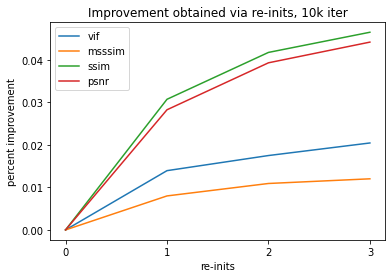

In [66]:
metrics_list = ['vif', 'msssim', 'ssim', 'psnr']

for mm, mu in enumerate(mu_inits):
    
    plt.plot(mu, label=metrics_list[mm])
    
plt.title('Improvement obtained via re-inits, 10k iter')
plt.ylabel('percent improvement')
plt.xlabel('re-inits')
plt.xticks([0,1,2,3])
plt.legend()
plt.show()

### avg metrics across all samples

In [13]:
print(mtr_id_list)

mu_bl = np.around(np.mean(metrics_bl, 0), 4)
mu_new = np.around(np.mean(metrics_new, 0), 4)
mu_diff = mu_new - mu_bl
print('\n', mu_bl, '\n', mu_new, '\n\n', mu_diff, '\n', mu_new/mu_bl)

['005', '006', '030', '065', '066', '080']

 [[ 0.893   0.9713  0.8653 33.4634]
 [ 0.7528  0.9471  0.8067 33.4589]] 
 [[ 0.907   0.9805  0.9041 35.1418]
 [ 0.7864  0.9604  0.8478 34.7602]] 

 [[0.014  0.0092 0.0388 1.6784]
 [0.0336 0.0133 0.0411 1.3013]] 
 [[1.01567749 1.00947184 1.04483994 1.05015629]
 [1.04463337 1.01404287 1.05094831 1.03889249]]


In [103]:
[[1.00727529 1.00987013 1.04319498 1.039946  ]
 [1.02094387 1.01509798 1.04990202 1.03119549]]

array([[0.92841346, 0.97775468, 0.92534429, 0.91234387],
       [0.92436975, 0.97379725, 0.93235759, 0.95641564]])

### indiv sample metrics

In [16]:
for idx_s, mtr_id in enumerate(mtr_id_list):
    
    print(mtr_id)
    print(metrics_bl[idx_s])
    print(metrics_new[idx_s])
    sys.exit()

005
[[ 0.8607  0.9619  0.8307 31.2403]
 [ 0.5459  0.9     0.6819 30.1073]]
[[ 0.8633  0.9567  0.8091 30.7887]
 [ 0.552   0.8983  0.6574 30.0567]]


SystemExit: 

### plot

SystemExit: 

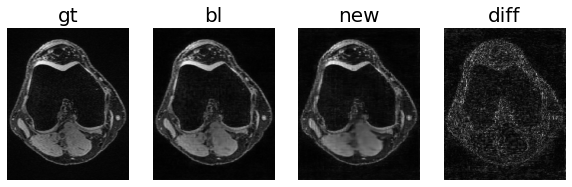

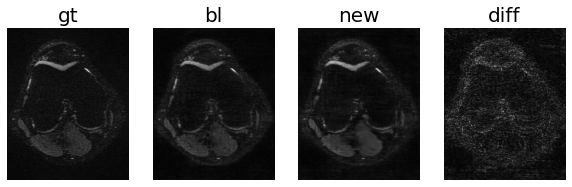

In [105]:
title_list = ['gt', 'bl', 'new']
clim_list = [None] * len(title_list)
DIFF_MAP = True

for idx_s in np.arange(imgs_gt.shape[0]):
    for idx_e in np.arange(imgs_gt.shape[1]):
        
        im_gt, im1, im2 = imgs_gt[idx_s, idx_e], \
                          imgs_bl[idx_s, idx_e], \
                          imgs_new[idx_s, idx_e]
#         im_gt, im1, im2 = scale_0_1(im_gt), scale_0_1(im1), scale_0_1(im2)
        arr_list = [im_gt, im1, im2]
        
        if DIFF_MAP:
            C = 4 # constant for plotting on clim=(0,1)
            im_diff = C * np.abs(scale_0_1(im1) - scale_0_1(im2))
            arr_list.append(im_diff)
            title_list.append('diff')
            clim_list.append((0,1))
                
        plot_row_qdess(arr_list, title_list, clim_list)
        
    sys.exit()